### Take a look at results from inter-trial interval decoding of highest valued-feature. 


### Current status: 
- Decoding accuracies look good, withstanding shuffle test
- Looked at weights briefly, seems weights within dimensions are more orthogonal, weights out of dimensions are more anti correlated

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *


import scipy


In [2]:
PRE_INTERVAL = 500
POST_INTERVAL = 500
INTERVAL_SIZE = 50
SMOOTH = 1
EVENT = "CrossFixation"
OUTPUT_DIR = "/data/patrick_res/hyak/pseudo"
# path to a dataframe of sessions to analyze
SESSIONS_PATH = "/data/patrick_res/sessions/valid_sessions_rpe.pickle"

num_shuffles = 8

In [11]:
test_accs = np.load(os.path.join(OUTPUT_DIR, "intertrial_agg_max_feat_test_accs.npy")).reshape((-1))
train_accs = np.load(os.path.join(OUTPUT_DIR, "intertrial_agg_max_feat_train_accs.npy")).reshape((-1))
mean_sub_test_accs = np.load(os.path.join(OUTPUT_DIR, "intertrial_agg_max_feat_block_mean_sub_test_accs.npy")).reshape((-1))
# shuffle_accs = np.load(os.path.join(OUTPUT_DIR, "intertrial_agg_max_feat_shuffle_{shuffle_seed}_train_accs.npy")).reshape((-1))

In [12]:
shuffle_accs = []
for i in range(num_shuffles):
    shuffle_acc = np.load(os.path.join(OUTPUT_DIR, f"intertrial_agg_max_feat_shuffle_{i}_test_accs.npy")).reshape((-1))
    shuffle_accs.append(shuffle_acc)
shuffle_accs = np.concatenate(shuffle_accs)

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:0'` for same effect.
  warnings.warn(msg, FutureWarning)


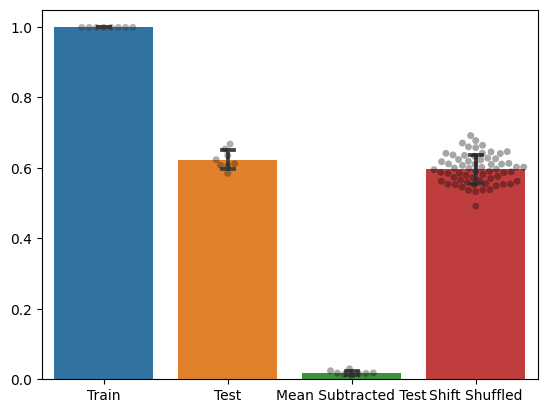

In [13]:
fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_bars([train_accs, test_accs, mean_sub_test_accs, shuffle_accs], ["Train", "Test", "Mean Subtracted Test", "Shift Shuffled"], ax)

### Want to see if there's any difference between inter vs. extra-dimensional feature axes orthogonality/dot prob/cosine sim

In [12]:
models = np.load(os.path.join(OUTPUT_DIR, "intertrial_agg_max_feat_models.npy"), allow_pickle=True)

In [16]:
def weights_to_arr(models):
    """
    assumes models of num_time_bins x num_splits
    each model has num_classes weights
    converts into np arr of num_time_bins, num_splits, num_units, num_classes
    """
    weights = np.empty((
        models.shape[0], 
        models.shape[1], 
        models[0, 0].coef_.T.shape[0],
        models[0, 0].coef_.T.shape[1],
    ))
    for time_idx, splits_idx in np.ndindex(models.shape):
        weights[time_idx, splits_idx, :, :] = models[time_idx, splits_idx].coef_.T
    return weights


In [20]:
weights = weights_to_arr(models).squeeze()

In [22]:
# num splits, num units, num features. 
weights.shape

(8, 566, 12)

In [42]:
# want to see: across features, how much does the norm of the vectors change when averaging? 
# bar plot of feature vector norms, bar plot of feature vector norms averaged across splits

# avg by splits and classes
meaned = np.mean(weights, axis=(0, 2))
avg_all_norm = np.sqrt(np.sum(meaned ** 2))

#avg by splits first: 
meaned = np.mean(weights, axis=0)
sqrd = meaned ** 2
avg_split_norms = np.sqrt(np.sum(sqrd, axis=0))

# don't avg first
sqrd = weights ** 2
norms = np.sqrt(np.sum(sqrd, axis=1)).reshape(-1)

In [44]:
avg_all_norm

0.06188711151419997

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:0'` for same effect.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 37.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


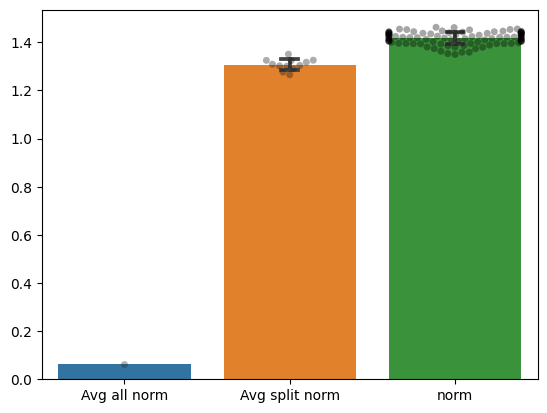

In [45]:
fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_bars([[avg_all_norm], avg_split_norms, norms], ["Avg all norm", "Avg split norm", "norm"], ax)

In [37]:
meaned.shape

(566, 12)

In [40]:
in_dim = []
out_dim = []
for i in range(12):
    for j in range(i + 1, 12):
        vec_i = meaned[:, i]
        vec_j = meaned[:, j]
        feat_i = FEATURES[i]
        feat_j = FEATURES[j]
        dot = np.dot(vec_i, vec_j)
        if FEATURE_TO_DIM[feat_i] == FEATURE_TO_DIM[feat_j]:
            in_dim.append(dot)
        else:
            out_dim.append(dot)

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:0'` for same effect.
  warnings.warn(msg, FutureWarning)


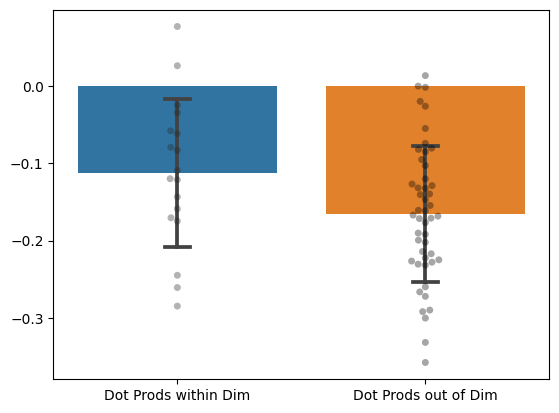

In [41]:
fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_bars([in_dim, out_dim], ["Dot Prods within Dim", "Dot Prods out of Dim"], ax)